# Homework 3 (WIP)

Write a solver for the regularized $p$-Laplacian,
$$ -\nabla\cdot\big( \kappa(\nabla u) \nabla u \big) = 0 $$
where
$$ \kappa(\nabla u) = \big(\frac 1 2 \epsilon^2 + \frac 1 2 \nabla u \cdot \nabla u \big)^{\frac{p-2}{2}}, $$
$ \epsilon > 0$, and $1 < p < \infty$.  The case $p=2$ is the conventional Laplacian. This problem gets more strongly nonlinear when $p$ is far from 2 and when $\epsilon$ approaches zero. The $p \to 1$ limit is related to plasticity and has applications in non-Newtonion flows and structural mechanics.

1. Implement a "Picard" solver, which is like a Newton solver except that the Jacobian is replaced by the linear system
$$ J_{\text{Picard}}(u) \delta u \sim -\nabla\cdot\big( \kappa(\nabla u) \nabla \delta u \big) . $$
This is much easier to implement than the full Newton linearization.  How fast does this method converge for values of $p < 2$ and $p > 2$?

* Use the linearization above as a preconditioner to a Newton-Krylov method.  That is, use [`scipy.sparse.linalg.LinearOperator`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.LinearOperator.html) to apply the Jacobian to a vector
$$ \tilde J(u) v = \frac{F(u + h v) - F(u)}{h} . $$
Then for each linear solve, use [`scipy.sparse.linalg.gmres`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.gmres.html) and pass as a preconditioner, a direct solve with the Picard linearization above. (You might find [`scipy.sparse.linalg.factorized`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.factorized.html#scipy.sparse.linalg.factorized) to be useful. Compare algebraic convergence to that of the Picard method.

* Can you directly implement a Newton linearization?  Either do it or explain what is involved.  How will its nonlinear convergence compare to that of the Newton-Krylov method?

In [1]:
%precision 3
%matplotlib notebook

import numpy
from matplotlib import pyplot
import scipy.sparse as sp
import scipy.sparse.linalg
pyplot.style.use('ggplot')

## Picard Solver Implementation

The code below implements a Picard solver for the _p_-Laplacian problem,
$$ -\nabla\cdot\big( \kappa(\nabla u) \nabla u \big) = f(x,y)\\
\kappa(\nabla u) = \big(\frac 1 2 \epsilon^2 + \frac 1 2 \nabla u \cdot \nabla u \big)^{\frac{p-2}{2}} $$

 0: anorm 1.000000e+00
 1: anorm 7.993606e-15


<IPython.core.display.Javascript object>


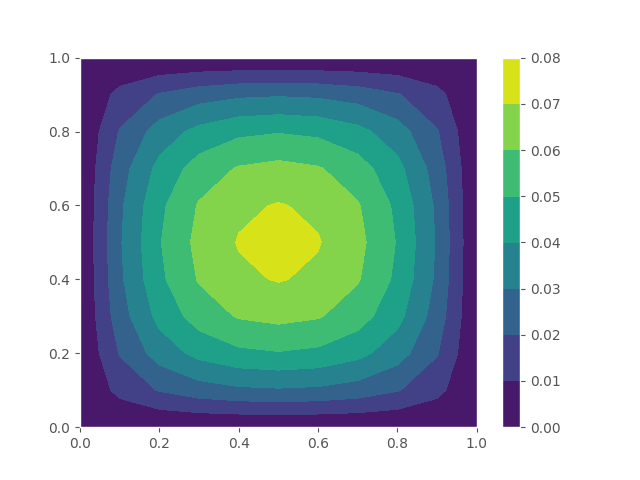

In [2]:
def hgrid(h):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    return x, y

def nonlinear2d_div(h, x, y, u, forcing, g0, eps, p, dirichlet=((),())):
    # Approximates a solution to the P-Laplacian:
    #   -1 * div(kappa(grad(u)) * grad(u)) = 0
    #   kappa(grad(u)) = 
    #       ((0.5 * eps^2) + (0.5 * grad(u) dot grad(u))) ^ ((p-2)/2)
    #
    # Parameters:
    #   h: grid size (the value passed to hgrid)
    #   x: x-coordinates of the grid
    #   y: y-coordinates of the grid
    #   u: the current approximation for u 
    #   forcing: f(x,y) forcing function for the problem
    #   g0: function for Dirichlet boundary -- u(x,y) = g0(x, y)
    #   eps: value of epsilon in the P-Laplacian
    #   p: value of p in the P-Laplacian
    #   dirichlet: where to impose Dirichlet boundary conditions (x, y)
    #       - first element can be 0 for left boundary
    #       - second element can be -1 for right boundary 
    #     E.g., ((0, -1), (0, -1)) for all Dirichlet conditions
    #     (0 and -1 are used as array indices: first and last elements)
    
    # Stencil to evaluate gradient at four staggered points
    grad = numpy.array([[-1, 0, 1, 0, 0],
                        [0, -1, 1, 0, 0],
                        [0, 0, -1, 1, 0],
                        [0, 0, -1, 0, 1]]) / h
    # Stencil to compute divergence at cell centers from fluxes at four 
    # staggered points
    div = numpy.array([-1, -1, 1, 1]) / h

    m = x.shape[0]
    u0 = g0(x, y).flatten()
    
    F = -forcing(x, y).flatten()
    
    # COO representation of the A matrix (the WIP J)
    ai = []
    aj = []
    av = []

    # Convenience function for accessing grid elements
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j

    # Create the mask and set the indices corresponding to Dirichlet BCs to 0
    mask = numpy.ones_like(x, dtype=bool)
    mask[dirichlet[0],:] = False
    mask[:,dirichlet[1]] = False
    mask = mask.flatten()

    u = u.flatten()
    F[mask == False] = u[mask == False] - u0[mask == False]
    u[mask == False] = u0[mask == False]

    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = numpy.array([idx(*pair) for pair in [
                (i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
            ustencil = u[stencili]
            ugrad = grad @ ustencil
            
            kappa = numpy.zeros_like(ugrad) + (
                0.5 * eps ** 2 + 0.5 * numpy.inner(ugrad, ugrad)) ** ((p-2) / 2)
            
            if mask[row] == 0: # If this (i, j) is on a Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
            else:
                F[row] -= div @ (kappa[:,None] * grad @ ustencil)
                Jstencil = -div @ (kappa[:,None] * grad)
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask].tolist()
                av += Jstencil[smask].tolist()

    J = sp.csr_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return F, J
    

def solve_nonlinear(h, g0, forcing, eps, p, dirichlet, atol=1e-8, verbose=False):
    x, y = hgrid(h)
    u = 0*x
    
    # Each time around the loop, you'll start with a new initial guess u
    for i in range(50):
        # Compute residual and Jacobian at u
        F, J = nonlinear2d_div(h, x, y, u, forcing,
                               g0, # g0, Dirichlet BC function
                               eps, 
                               p, 
                               dirichlet=((0,-1),(0,-1))) # all Dirichlet BCs
        
        # Break if the residual norm is lower than the tolerance
        anorm = numpy.linalg.norm(F, numpy.inf)
        if verbose:
            print('{:2d}: anorm {:8e}'.format(i,anorm))
        if anorm < atol:
            break
            
        # Solve and take a step
        deltau = sp.linalg.spsolve(J, -F)
        u += deltau.reshape(x.shape)

    return x, y, u, i


x, y, u, i = solve_nonlinear(.1, 
    lambda x,y: 0*x,   # g0
    lambda x,y: 0*x+1, # forcing
    eps = 1,
    p = 2,
    dirichlet=((0,-1),(0,-1)),
    verbose=True)
pyplot.figure()
pyplot.contourf(x, y, u)
pyplot.colorbar();

### Testing with a Manufactured Solution

To verify the results of the solver, we'll use a manufactured solution. Specifically, it'll be the one from lecture:
$$ u(x, y) = x e^{-2x} \tanh(1.2y+0.1) $$
To evaluate the terms needed in the problem, we'll use SymPy.

For the moment, here's one test to look at.

 0: anorm 2.418461e+01
 1: anorm 1.465494e-14


<IPython.core.display.Javascript object>


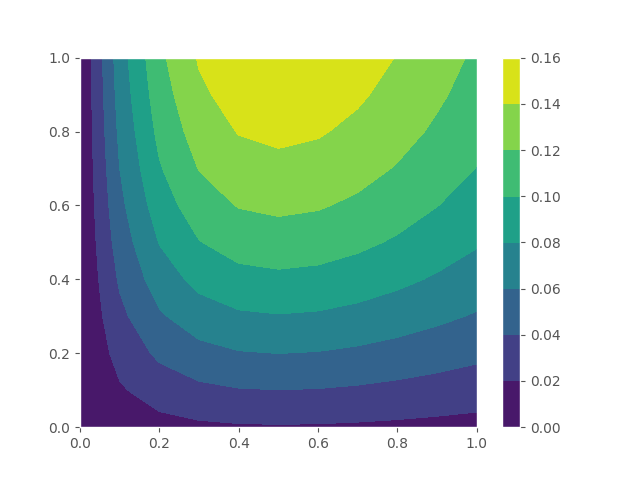

<IPython.core.display.Javascript object>


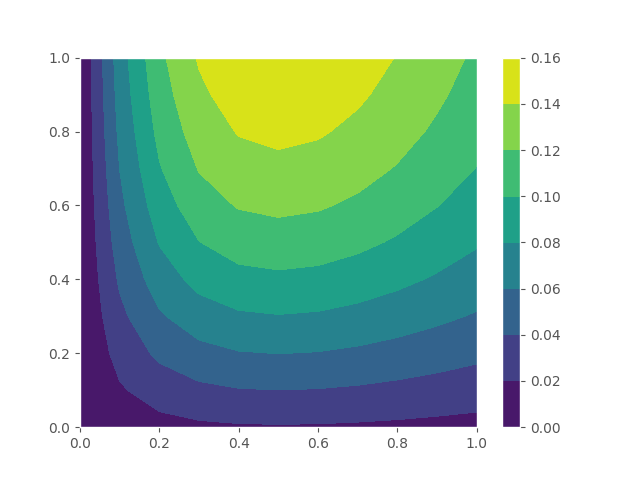

In [3]:
class mms_p_laplacian:
    def __init__(self, eps = 0, p = 2):
        import sympy
        from sympy.vector import gradient
        x, y = sympy.symbols('x y')

        uexpr = x * sympy.exp(-2*x) * sympy.tanh(1.2*y+.1)
        def grad_u(xx, yy):
            ux = sympy.lambdify((x,y), sympy.diff(u, x))
            uy = sympy.lambdify((x,y), sympy.diff(u, y))
            return ux(xx, yy), uy(xx, yy)
        self.u = sympy.lambdify((x,y), uexpr)
        
        graduexpr = gradient(uexpr)
        
        kexpr = ((0.5 * eps **2) + (0.5 * graduexpr.dot(graduexpr))) ** ((p-2)/2)
        self.kappa = sympy.lambdify((x,y), kexpr)
        def grad_kappa(xx, yy):
            kx = sympy.diff(kappa, x)
            ky = sympy.diff(kappa, y)
            return kx(xx, yy), ky(xx, yy)
        
        self.div_kappa_grad_u = sympy.lambdify((x,y),
                                              -(  sympy.diff(kexpr * sympy.diff(uexpr, x), x)
                                                + sympy.diff(kexpr * sympy.diff(uexpr, y), y)))    

eps = 1
p = 2

mms = mms_p_laplacian(eps, p)
x, y, u, i = solve_nonlinear(.1, 
    mms.u,   # g0
    mms.div_kappa_grad_u, # forcing
    eps = eps,
    p = p,
    dirichlet=((0,-1),(0,-1)),
    verbose=True)

pyplot.figure()
pyplot.contourf(x, y, u)
pyplot.colorbar();

pyplot.figure()
pyplot.contourf(x, y, mms.u(x,y))
pyplot.colorbar();